In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import matplotlib.colors as mpc
import os
import yt
import tqdm
import re
import pandas as pd
import sklearn.gaussian_process as gp


In [2]:
outputs_dir = "MD_outputs"
if not os.path.exists(outputs_dir):
    os.makedirs(outputs_dir)
os.chdir(outputs_dir)

In [3]:
def calculate_values(ad, V_app, inputs):
    shape = tuple(inputs['n_cell'][:-1])
    
    if not shape == (64, 64):
        raise ValueError(f"Expected xy dimensions of (64, 64), got {shape}")
    
    P_array = ad['Pz'].to_ndarray().reshape(ad.ds.domain_dimensions)
    Phi_array = ad['Phi'].to_ndarray().reshape(ad.ds.domain_dimensions)
    Ez_array = ad['Ez'].to_ndarray().reshape(ad.ds.domain_dimensions)

    idx_fede_lo = 20        # int(inputs['FE_lo'] / inputs['dz'])
    idx_fede_hi = 21        # idx_fede_lo + 1
    idx_sc_hi = 19          # int(inputs['SC_hi'] / inputs['dz']) - 1
    l = inputs['l']
    
    epsilon_0 = inputs['epsilon_0']
    epsilon_de = inputs['epsilon_de']
    
    x = np.linspace(inputs['prob_lo'][0], inputs['prob_hi'][0], inputs['n_cell'][0])
    
    #Calculate V_fe_avg
    V_FeDe = 0.5 * (Phi_array[:, :, idx_fede_lo] + Phi_array[:, :, idx_fede_hi])
    # V_FeDe = Phi_array[:,:,index_fede_lo]
    integral_V = 1 / l * 1 / l * np.trapz(np.trapz(V_FeDe, x), x)
    V_fe_avg = V_app - integral_V
    
    #Calculate Q
    Ez_FeDe = 0.5 * (Ez_array[:, :, idx_fede_lo] + Ez_array[:, :, idx_fede_hi])
    P_FeDe = 0.5 * (P_array[:, :, idx_fede_lo] + P_array[:, :, idx_fede_hi])
    D_FeDe = epsilon_0 * epsilon_de * Ez_FeDe + P_FeDe
    Q = -1 / l * 1 / l * np.trapz(np.trapz(D_FeDe, x), x)
    
    #Calculate Surface potential
    V_Sc = Phi_array[:, :, idx_sc_hi]
    Phi_S = np.mean(V_Sc)     # Prabhat had this stored in variable xsi
    
    return V_fe_avg, Q, Phi_S

In [4]:
def read_inputs(tfe_dir):
    ret = dict()
    with open(f'{tfe_dir}/inputs', 'r') as f:
        for line in map(lambda x: x.strip(), f):
            if len(line) == 0:
                continue
            key, val = re.split('\s*=\s*', line)
            val = [float(_) if '.' in _ or 'e' in _ else int(_) for _ in re.split('\s+', val)]
            if len(val) == 1:
                val = val[0]
            ret[key] = val
    return ret

In [5]:
def copy_keys(src, dest):
    for k in ('alpha', 'beta', 'gamma', 'g11', 'g44', 'epsilon_de', 'epsilon_si', 'epsilonZ_fe'):
        dest[k] = src[k]

def get_design_params(inputs):
    ret = dict()
    ret['L_z_SC'] = inputs['SC_hi'] - inputs['SC_lo']
    ret['L_z_DE'] = inputs['DE_hi'] - inputs['DE_lo']
    ret['L_z_FE'] = inputs['FE_hi'] - inputs['FE_lo']
    ret['L_x'] = inputs['prob_hi'][0] - inputs['prob_lo'][0]
    ret['L_y'] = inputs['prob_hi'][1] - inputs['prob_lo'][1]
    copy_keys(inputs, ret)
    return ret

def new_inputs(dp):
    inputs = dict()
    
    inputs['SC_lo'] = 0.0
    inputs['SC_hi'] = dp['L_z_SC']
    inputs['DE_lo'] = inputs['SC_hi']
    inputs['DE_hi'] = inputs['DE_lo'] + dp['L_z_DE']
    inputs['FE_lo'] = inputs['DE_hi'] 
    inputs['FE_hi'] = inputs['FE_lo'] + dp['L_z_FE']
    
    inputs['prob_lo'] = [-dp['L_x'] / 2, -dp['L_y'] / 2, 0.0]
    inputs['prob_hi'] = [ dp['L_x'] / 2,  dp['L_y'] / 2, inputs['FE_hi']]

    copy_keys(dp, inputs)
    return inputs

In [6]:
yt.utilities.logger.set_log_level('warning')

data_dir = f"{os.environ['SCRATCH']}/bml/MD"

all_names = list()
all_data = list()
tfes = list()

it = sorted(glob.glob(f"{data_dir}/*nm"))
it = tqdm.tqdm(it)

all_V_app = list()
all_Q = list()
all_V_fe_avg = list()
all_Phi_S = list()

design_params = list()

inputs_tmpl = None

for tfe_dir in it:
    tfes.append(float(tfe_dir[tfe_dir.rfind('/')+1:-2]))
    inputs = read_inputs(tfe_dir)
    inputs_tmpl = inputs.copy()
    inputs.setdefault('l', 32e9)

    design_params.append(get_design_params(inputs))
    names = list()
    data = {'Px': list(), 'Py': list(), 'Pz': list()}
    
    V_app = list()
    Q = list()
    V_fe_avg = list()
    Phi_S = list()
    
    for i in sorted(glob.glob(f"{tfe_dir}/plt*")):
        if 'old' in i:
            continue
        it = int(i.split('/')[-1][3:])
        if not (it > 0 and it % inputs['inc_step'] == 0):
            continue
        _V_app = ((it // inputs['inc_step']) - 1) / 10
        ds = yt.load(i)
        name = i[i.find('plt')+3:]
        names.append(name)

        ad = ds.all_data()
        
        _V_fe_avg, _Q, _Phi_S = calculate_values(ad, _V_app, inputs)
        
        V_app.append(_V_app)
        Q.append(_Q)
        V_fe_avg.append(_V_fe_avg)
        Phi_S.append(_Phi_S)
        
    order = np.argsort(V_app)
    all_V_app.append(np.array(V_app)[order])
    all_Q.append(np.array(Q)[order])
    all_V_fe_avg.append(np.array(V_fe_avg)[order])
    all_Phi_S.append(np.array(Phi_S)[order])
    
order = np.argsort(tfes)

design_params = pd.DataFrame(data=design_params).iloc[order]
tfe = np.array(tfes)[order]
V_app = np.array(all_V_app)[order]
Q = np.array(all_Q)[order]
V_fe_avg = np.array(all_V_fe_avg)[order]
Phi_S = np.array(all_Phi_S)[order]

100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


In [7]:
dPhiS_dVapp = (np.diff(Phi_S) / np.diff(V_app))

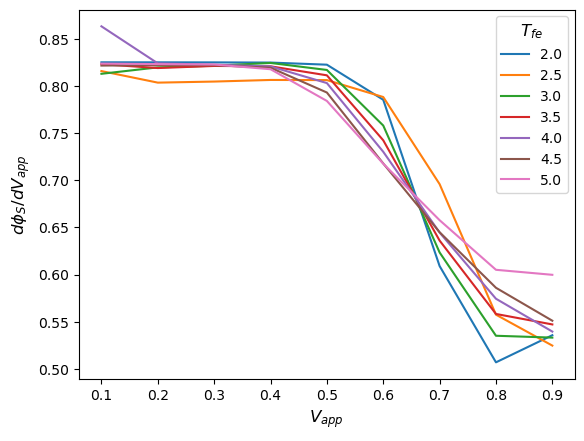

In [8]:
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'lightblue', 'purple']

_V_app = V_app[0, 1:]

for i in range(len(tfe)):
    plt.plot(_V_app, dPhiS_dVapp[i], label=tfes[i])
##########

plt.legend(title="$T_{fe}$", title_fontsize=12)
plt.xlabel("$V_{app}$", fontsize=12)
plt.ylabel("$d\phi_S/dV_{app}$", fontsize=12)
plt.savefig("dPhiS_dVapp.png", dpi=100)

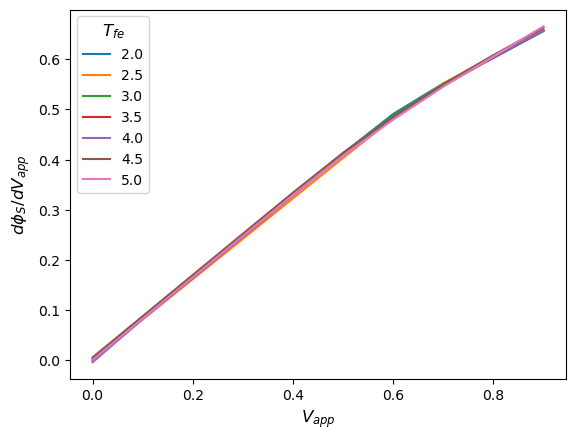

In [9]:
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'lightblue', 'purple']

for i in range(len(tfe)):
    plt.plot(V_app[0], Phi_S[i], label=tfes[i])
plt.legend(title="$T_{fe}$", title_fontsize=12)
plt.xlabel("$V_{app}$", fontsize=12)
plt.ylabel("$d\phi_S/dV_{app}$", fontsize=12)
plt.savefig("PhiS_Vapp.png", dpi=100)

In [10]:
design_params

,L_z_SC,L_z_DE,L_z_FE,L_x,L_y,alpha,beta,gamma,g11,g44,epsilon_de,epsilon_si,epsilonZ_fe
0,1.000000e-08,1.000000e-09,2.000000e-09,3.200000e-08,3.200000e-08,-2.500000e+09,6.000000e+10,1.500000e+11,1.000000e-09,1.000000e-09,3.9,11.7,24.0
1,1.000000e-08,1.000000e-09,2.500000e-09,3.200000e-08,3.200000e-08,-2.500000e+09,6.000000e+10,1.500000e+11,1.000000e-09,1.000000e-09,3.9,11.7,24.0
2,1.000000e-08,1.000000e-09,3.000000e-09,3.200000e-08,3.200000e-08,-2.500000e+09,6.000000e+10,1.500000e+11,1.000000e-09,1.000000e-09,3.9,11.7,24.0
3,1.000000e-08,1.000000e-09,3.500000e-09,3.200000e-08,3.200000e-08,-2.500000e+09,6.000000e+10,1.500000e+11,1.000000e-09,1.000000e-09,3.9,11.7,24.0
4,1.000000e-08,1.000000e-09,4.000000e-09,3.200000e-08,3.200000e-08,-2.500000e+09,6.000000e+10,1.500000e+11,1.000000e-09,1.000000e-09,3.9,11.7,24.0
5,1.000000e-08,1.000000e-09,4.500000e-09,3.200000e-08,3.200000e-08,-2.500000e+09,6.000000e+10,1.500000e+11,1.000000e-09,1.000000e-09,3.9,11.7,24.0
6,1.000000e-08,1.000000e-09,5.000000e-09,3.200000e-08,3.200000e-08,-2.500000e+09,6.000000e+10,1.500000e+11,1.000000e-09,1.000000e-09,3.9,11.7,24.0


In [11]:
# Train initial Gaussian Process (GP) model

from sklearn.preprocessing import MaxAbsScaler
import scipy.stats as st
import sklearn.gaussian_process as gp



X_train = design_params.values
y_train = np.max(dPhiS_dVapp, axis=1)

#.fit(X_train)

scaler = MaxAbsScaler()
kernel = gp.kernels.ConstantKernel(1.0, (1e-5, 1e5)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, 
                                    optimizer='fmin_l_bfgs_b',
                                    n_restarts_optimizer=30, 
                                    alpha=1e-10, 
                                    normalize_y=True)

In [12]:
model.fit(scaler.transform(X_train), y_train)

/pscratch/sd/a/ajtritt/.conda/envs/bml/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=30, normalize_y=True)

In [13]:
bounds = np.array([X_train.min(axis=0), X_train.max(axis=0)]).T
candidates = np.array([np.random.uniform(low=bounds[:, 0], high=bounds[:, 1]) for _ in range(10)])

In [14]:
# GP prediction
y_pred, pred_std = model.predict(scaler.transform(candidates), return_std=True)

In [15]:
# Expected Improvement-based active learning function
def EI_learning(candidates, y_pred, pred_std):
    """Active learning function based on expected improvement
       
       This function selects a new sample from candidate pool to enrich the current training dataset.
       The sample gets selected if it has the maximum expected improvement value.
       
       Input: 
       - candidates: pool of candidates to select sample from
       - y_pred: GP predictions on candidate samples
       - pred_std: Standard deviation of the GP predictions on candidate samples
       
       Output:
       - new_sample: the selected sample with the maximum expected improvement value
       - EI: EI values of the candidate samples
    """
    
    # 1-Find the current minimum
    current_objective = y_pred[np.argmin(y_pred)]
    
    # 2-Calculate the EI values of the candidate samples
    pred_std = pred_std.reshape(pred_std.shape[0])
    
    cdf = st.norm.cdf((current_objective-y_pred)/pred_std)
    dev = (current_objective - y_pred)
    pdf = st.norm.pdf((current_objective-y_pred)/pred_std)
    
    EI =  dev * cdf + pred_std * pdf 
    
    # 3-Select a new sample
    new_sample = candidates[np.argmax(EI)]
    
    return new_sample

In [43]:
inputs_tmpl.update(new_inputs(dict(zip(design_params.columns, EI_learning(candidates, y_pred, pred_std)))))
for k in inputs_tmpl:
    print(f"{k} = {fmt_param(inputs_tmpl[k])}")

n_cell = 64 64 32
max_grid_size = 64
prob_type = 2
P_BC_flag_lo = 0
P_BC_flag_hi = 1
Phi_Bc_lo = 0.0
Phi_Bc_hi = 0.0
nsteps = 20000
plot_int = 1000
Phi_Bc_inc = 0.1
inc_step = 2000
inc_step_sign_change = 22000
TimeIntegratorOrder = 1
dt = 2e-13
prob_lo = -1.6e-08 -1.6e-08 0.0
prob_hi = 1.6e-08 1.6e-08 1.39e-08
epsilon_0 = 8.85e-12
epsilonX_fe = 24
epsilonZ_fe = 24
epsilon_de = 3.9
epsilon_si = 11.7
alpha = -2.5e+09
beta = 6e+10
gamma = 1.5e+11
BigGamma = 100
g11 = 1e-09
g44 = 1e-09
g44_p = 0.0
g12 = 0.0
alpha_12 = 0.0
alpha_112 = 0.0
alpha_123 = 0.0
SC_lo = 0.0
SC_hi = 1e-08
DE_lo = 1e-08
DE_hi = 1.1e-08
FE_lo = 1.1e-08
FE_hi = 1.39e-08
lambda = 3e-09


In [18]:
type(inputs_tmpl['SC_hi']

numpy.float64

In [34]:
def fmt_param(param):
    if isinstance(param, list):
        return " ".join(fmt_param(_) for _ in param)
    elif isinstance(param, (int, np.int64)):
        return str(param)
    elif isinstance(param, (float, np.float64)):
        if param == 0.0:
            return '0.0'
        return f'{param:0.3g}'

fmt_param(inputs_tmpl['prob_hi'])

'1.6e-08 1.6e-08 1.39e-08'

In [35]:
for k in inputs_tmpl:
    print(f"{k} = {fmt_param(inputs_tmpl[k])}")

n_cell = 64 64 32
max_grid_size = 64
prob_type = 2
P_BC_flag_lo = 0
P_BC_flag_hi = 1
Phi_Bc_lo = 0.0
Phi_Bc_hi = 0.0
nsteps = 20000
plot_int = 1000
Phi_Bc_inc = 0.1
inc_step = 2000
inc_step_sign_change = 22000
TimeIntegratorOrder = 1
dt = 2e-13
prob_lo = -1.6e-08 -1.6e-08 0.0
prob_hi = 1.6e-08 1.6e-08 1.39e-08
epsilon_0 = 8.85e-12
epsilonX_fe = 24
epsilonZ_fe = 24
epsilon_de = 3.9
epsilon_si = 11.7
alpha = -2.5e+09
beta = 6e+10
gamma = 1.5e+11
BigGamma = 100
g11 = 1e-09
g44 = 1e-09
g44_p = 0.0
g12 = 0.0
alpha_12 = 0.0
alpha_112 = 0.0
alpha_123 = 0.0
SC_lo = 0.0
SC_hi = 1e-08
DE_lo = 1e-08
DE_hi = 1.1e-08
FE_lo = 1.1e-08
FE_hi = 1.39e-08
lambda = 3e-09


In [41]:
eps = inputs_tmpl['epsilonX_fe']
f'{eps:0.1f}'

'24.0'